In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime as dt
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from bokeh.plotting import figure, output_notebook, show
output_notebook()
import datashader as ds
from datashader import transfer_functions as tr_fns
from datashader.colors import Greys9


C:\Users\Aditya\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Loading BokehJS ...

In [2]:
df = pd.read_csv("green_tripdata_2015-09.csv").rename(columns=lambda x: x.strip())

In [3]:
print("Number of rows:",df.shape[0])
print("Number of columns:",df.shape[1])

Number of rows: 1494926
Number of columns: 21


### Cleaning

In [4]:
df.describe()

VendorID    RateCodeID  Pickup_longitude  Pickup_latitude  \
count  1.494926e+06  1.494926e+06      1.494926e+06     1.494926e+06   
mean   1.782045e+00  1.097653e+00     -7.383084e+01     4.069114e+01   
std    4.128570e-01  6.359437e-01      2.776082e+00     1.530882e+00   
min    1.000000e+00  1.000000e+00     -8.331908e+01     0.000000e+00   
25%    2.000000e+00  1.000000e+00     -7.395961e+01     4.069895e+01   
50%    2.000000e+00  1.000000e+00     -7.394536e+01     4.074674e+01   
75%    2.000000e+00  1.000000e+00     -7.391748e+01     4.080255e+01   
max    2.000000e+00  9.900000e+01      0.000000e+00     4.317726e+01   

       Dropoff_longitude  Dropoff_latitude  Passenger_count  Trip_distance  \
count       1.494926e+06      1.494926e+06     1.494926e+06   1.494926e+06   
mean       -7.383728e+01      4.069291e+01     1.370598e+00   2.968141e+00   
std         2.677911e+00      1.476698e+00     1.039426e+00   3.076621e+00   
min        -8.342784e+01      0.000000e+00     0.000000e+00   0.000000e+00   
25%        -7.396782e+01      4.069878e+01     1.000000e+00   1.100000e+00   
50%        -7.394504e+01      4.074728e+01     1.000000e+00   1.980000e+00   
75%        -7.391013e+01      4.079015e+01     1.000000e+00   3.740000e+00   
max         0.000000e+00      4.279934e+01     9.000000e+00   6.031000e+02   

        Fare_amount         Extra       MTA_tax    Tip_amount  Tolls_amount  \
count  1.494926e+06  1.494926e+06  1.494926e+06  1.494926e+06  1.494926e+06   
mean   1.254320e+01  3.512800e-01  4.866408e-01  1.235727e+00  1.231047e-01   
std    1.008278e+01  3.663096e-01  8.504473e-02  2.431476e+00  8.910137e-01   
min   -4.750000e+02 -1.000000e+00 -5.000000e-01 -5.000000e+01 -1.529000e+01   
25%    6.500000e+00  0.000000e+00  5.000000e-01  0.000000e+00  0.000000e+00   
50%    9.500000e+00  5.000000e-01  5.000000e-01  0.000000e+00  0.000000e+00   
75%    1.550000e+01  5.000000e-01  5.000000e-01  2.000000e+00  0.000000e+00   
max    5.805000e+02  1.200000e+01  5.000000e-01  3.000000e+02  9.575000e+01   

       Ehail_fee  improvement_surcharge  Total_amount  Payment_type  \
count        0.0           1.494926e+06  1.494926e+06  1.494926e+06   
mean         NaN           2.920991e-01  1.503215e+01  1.540559e+00   
std          NaN           5.074009e-02  1.155316e+01  5.232935e-01   
min          NaN          -3.000000e-01 -4.750000e+02  1.000000e+00   
25%          NaN           3.000000e-01  8.160000e+00  1.000000e+00   
50%          NaN           3.000000e-01  1.176000e+01  2.000000e+00   
75%          NaN           3.000000e-01  1.830000e+01  2.000000e+00   
max          NaN           3.000000e-01  5.813000e+02  5.000000e+00   

          Trip_type  
count  1.494922e+06  
mean   1.022353e+00  
std    1.478288e-01  
min    1.000000e+00  
25%    1.000000e+00  
50%    1.000000e+00  
75%    1.000000e+00  
max    2.000000e+00

#### RateCodeID has values greater than 6 which is not possible according to the data dictionary, changing that to the most common value of the column. 

#### Ehail_fee is a column of NaN's, dropping the column.

#### Fare_amount, Extra, MTA_tax, Tip_amount, Tolls_amount, improvement_surcharge and Total_amount have negative values. Changing that to the absolute values.

#### Trip_distance has a maximum value of over 600 miles. An interborugh travel of more than 100 miles is absurd. Dropping values greater than 100 miles.

In [5]:
### Changing values in RateCodeID greater than 6 to the most common value

df['RateCodeID'][df["RateCodeID"]>6]=df['RateCodeID'].value_counts().idxmax()


C:\Users\Aditya\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
### Dropping Ehail_fee

df.drop(['Ehail_fee'], axis=1, inplace=True)

In [7]:
### Converting Fare_amount, Extra, MTA_tax, Tip_amount, Tolls_amount, improvement_surcharge and Total_amount to absolute values

df['Fare_amount'] = df["Fare_amount"].abs()
df['Extra'] = df['Extra'].abs()
df['MTA_tax'] = df['MTA_tax'].abs()
df['Tip_amount'] = df['Tip_amount'].abs()
df['Tolls_amount'] = df['Tolls_amount'].abs()
df['improvement_surcharge'] = df['improvement_surcharge'].abs()
df['Total_amount'] = df['Total_amount'].abs()

In [8]:
### Removing Trip distance values greater than 100 miles
df = df[df["Trip_distance"]<100]

In [9]:
### Checking the NaN values in the data
df.isna().sum()

VendorID                 0
lpep_pickup_datetime     0
Lpep_dropoff_datetime    0
Store_and_fwd_flag       0
RateCodeID               0
Pickup_longitude         0
Pickup_latitude          0
Dropoff_longitude        0
Dropoff_latitude         0
Passenger_count          0
Trip_distance            0
Fare_amount              0
Extra                    0
MTA_tax                  0
Tip_amount               0
Tolls_amount             0
improvement_surcharge    0
Total_amount             0
Payment_type             0
Trip_type                4
dtype: int64

#### Changing the NaN values in Trip_type to most common value in the column

In [10]:
df['Trip_type'] = df['Trip_type'].fillna(df['Trip_type'].value_counts().idxmax())

Text(0.5,1,'Histogram of trip distance with outliers removed')

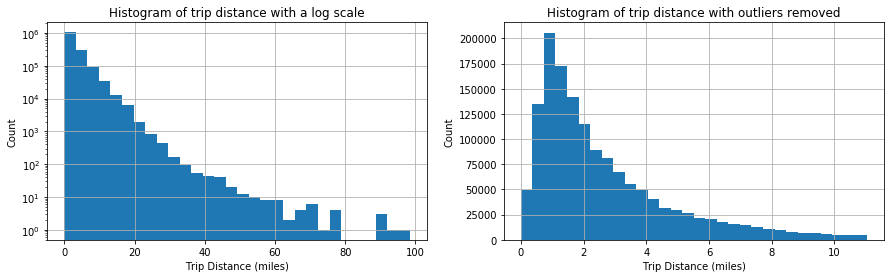

In [11]:
fig,ax = plt.subplots(1,2,figsize = (15,4)) 

# histogram of the number of trip distance
df['Trip_distance'].hist(bins=30,ax=ax[0])
ax[0].set_xlabel('Trip Distance (miles)')
ax[0].set_ylabel('Count')
ax[0].set_yscale('log')
ax[0].set_title('Histogram of trip distance with a log scale')

# Excluding the values which are 3 standard deviations farther away from the median
x = df['Trip_distance']
x[((x-x.median()).abs()<3*x.std())].hist(bins=30,ax=ax[1])
ax[1].set_xlabel('Trip Distance (miles)')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of trip distance with outliers removed')

The distribution of the histograms is right skewed as there is a lower boundary of 0, as trip distance can't be negative. The frequency of trip distance peaks at 1.5 miles and then there is an exponential decrease. 

On the left I have plotted a histogram of trip distance with log scale. On the right, I removed the outliers in the data, outliers here are defined as any observation which is 3 standard deviation farther away from the median. 

#### Hypothesis:
There is a log normal distribution present here. I hypothesize that since there is no Gaussian distribution so these trips aren't random. The reason of the left skew could be people who stay relatively close to their workplace taking cabs to work.  

In [12]:
### Getting datetime values in right format
df['pickup'] = df['lpep_pickup_datetime'].apply(lambda x: dt.strptime(x, '%Y-%m-%d %H:%M:%S'))
df['dropoff'] = df['Lpep_dropoff_datetime'].apply(lambda x: dt.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [13]:
### Getting the hour from datetime column
df['pickup_hour'] = df['pickup'].apply(lambda x: x.hour)

In [14]:
### Creating a pivot table with trip distance grouped according to the pick up hour 
table = df.pivot_table(values='Trip_distance', index = 'pickup_hour', aggfunc=('mean','median')).reset_index()
table.columns = ['Pickup Hour', 'Mean Distance', 'Median Distance']

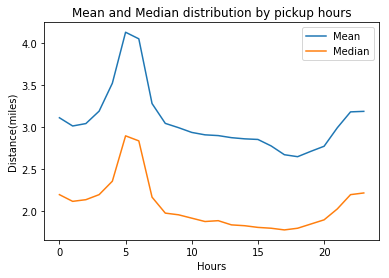

    Pickup Hour  Mean Distance  Median Distance
0             0       3.115276             2.20
1             1       3.017347             2.12
2             2       3.046176             2.14
3             3       3.193985             2.20
4             4       3.526555             2.36
5             5       4.133474             2.90
6             6       4.055149             2.84
7             7       3.284394             2.17
8             8       3.048450             1.98
9             9       2.997404             1.96
10           10       2.940787             1.92
11           11       2.912015             1.88
12           12       2.903065             1.89
13           13       2.878294             1.84
14           14       2.864304             1.83
15           15       2.857040             1.81
16           16       2.779852             1.80
17           17       2.675327             1.78
18           18       2.651864             1.80
19           19       2.715597          

In [15]:
plt.plot(table['Mean Distance'], label='Mean')
plt.plot(table['Median Distance'], label='Median')
plt.xlabel('Hours')
plt.ylabel('Distance(miles)') 
plt.title('Mean and Median distribution by pickup hours')
plt.legend(loc='upper right')
plt.show()
print(table)

#### There is an early morning peak and that can be explained due to everone hailing a cab to reach in time for early morning meetings at the office. There is a rather smooth curve in the evening and it seems people are taking public transport to work. It can also be explained by the fact that most of the offices are in Manhattan and Green cabs are not allowed to pick up passengers from Manhattan as specified in the question. 

I found the latitude and longitude values of two drop off and pickup locations on LaGuardia and made another column which fits these values. Newark and JFK could be found using the RateCodeID column. 

In [16]:
### Create a column with latitude and longitude values between two drop off and pick up locations
df["LGA"] = ((df['Pickup_longitude']<-73.865387) & (df['Pickup_longitude']>-73.884547)  &
            (df['Pickup_latitude'] < 40.773098) & (df['Pickup_latitude']>40.767550)) | ((df['Dropoff_longitude'] < -73.865387) & 
            (df['Dropoff_longitude'] > -73.884547) & (df['Dropoff_latitude'] < 40.773098) & (df['Dropoff_latitude']>40.767550))

In [17]:
df['LGA'].replace([True, False],[1, 0], inplace=True)

In [18]:
### Make a dataframe of values just consisting of trips to/from airports
airport_trips = df[(df['RateCodeID']==2) | (df['RateCodeID']==3) | (df['LGA']==1)]

In [19]:
print('Number of Trips to/from airports:', airport_trips.shape[0])
print('Average fare of trips:', round(airport_trips['Total_amount'].mean(),2))
print('Average Tips:', round(airport_trips['Tip_amount'].mean(),2))

Number of Trips to/from airports: 10772
Average fare of trips: 40.81
Average Tips: 3.08


In [20]:
table1 = airport_trips.pivot_table(values='Trip_distance', index = 'pickup_hour', aggfunc=('mean')).reset_index()

Text(0.5,1,'Distribution of trips to airports')

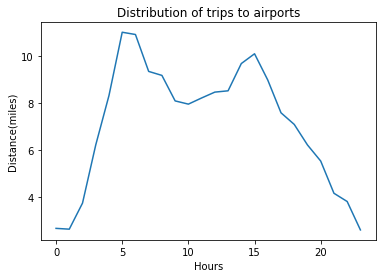

In [21]:
plt.plot(table1['Trip_distance'], label='Mean')
plt.xlabel('Hours')
plt.ylabel('Distance(miles)') 
plt.title('Distribution of trips to airports')

#### There is an early morning rush and another in the evening. It would be interesting to see what days of the week have this behavior. It could be explained by Consultants who usually fly in and out in the early morning and in the evening.

In [22]:
### Variabe for tip as a percentage of total fare
df['Tip_percent'] = 100*df['Tip_amount']/df['Total_amount']
df['Tip_percent']= df['Tip_percent'].fillna(0)

In [23]:
df[df['Tip_amount']==0]['Tip_amount'].count()/df.shape[0]

0.59678938482162214

Here we notice that almost 60% of cab rides didn't recieve any tips. For that purpose, building a classifier model to see first which cab rides get a tip and then trying to build a regression model to predict the tip amount as a percentage of total fare makes more sense. 

In [24]:
###Creating a target variable for classification first
df['Tip_given'] = (df['Tip_amount']>0)*1

In [25]:
### Getting a sample for tuning and optimization
df_sample = df.sample(n=10000, random_state=42)

#### Using the following columns for prediction, Passenger_count, Trip_distance, Fare_amount, Extra, MTA_tax, Tolls_amount, improvement_surcharge, Total_amount and Payment_type. Payment_type is a categorical variable and needs to be one hot encoded.

In [26]:
ohe = pd.get_dummies(df_sample['Payment_type'])
df_sample = pd.concat([df_sample,ohe], axis=1)

In [27]:
ohe_full = pd.get_dummies(df['Payment_type'])
df = pd.concat([df,ohe_full], axis=1)

In [28]:
X_clas = df_sample[['Passenger_count', 'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax', 'Tolls_amount', 'improvement_surcharge',
                  'Total_amount',1,2,3,4]]

y_clas = df_sample['Tip_given']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_clas,y_clas, test_size=0.3, stratify=y_clas)

In [30]:
X_clas.head()

Passenger_count  Trip_distance  Fare_amount  Extra  MTA_tax  \
1023836                1           1.82         10.0    0.5      0.5   
1108595                3           1.57          6.5    0.5      0.5   
611585                 1           2.90         12.0    0.5      0.5   
770211                 1           2.53         10.5    1.0      0.5   
954638                 1           3.30         14.0    0.5      0.5   

         Tolls_amount  improvement_surcharge  Total_amount  1  2  3  4  
1023836           0.0                    0.3         13.56  1  0  0  0  
1108595           0.0                    0.3         10.80  1  0  0  0  
611585            0.0                    0.3         13.30  0  1  0  0  
770211            0.0                    0.3         15.99  1  0  0  0  
954638            0.0                    0.3         15.30  0  1  0  0

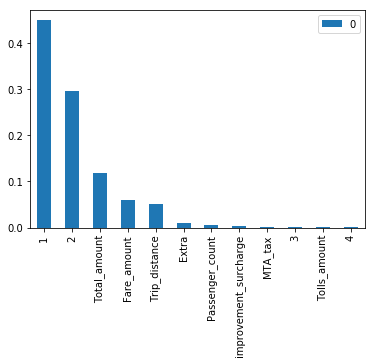

In [31]:
### Getting the feature importance for classification
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
importance =  (sorted(zip(map(lambda x: round(x, 4), rfc.feature_importances_), X_train.columns), 
             reverse=True))
pd.DataFrame(importance, index=[x for (_,x) in importance]).plot(kind = 'bar')

In [32]:
X_clas = df_sample[[1,2,'Total_amount','Fare_amount','Trip_distance']]
X_train, X_test, y_train, y_test = train_test_split(X_clas,y_clas, test_size=0.3, stratify=y_clas)

#### We can see that Payment type 1 & 2 (them being credit card and cash) along with Total_amount, Fare_amount and Trip_distance are the most important features in this model

In [33]:
grid_rf = { "n_estimators"      : [220,240,260],
               "criterion"         : ["gini", "entropy"],
               "max_depth"         : [10,15],
               "min_samples_split" : [6,10],
              "max_features": ['auto','log2','sqrt']
             }

In [34]:
rf = RandomForestClassifier()
random_search_rf = RandomizedSearchCV(rf, grid_rf, cv=10, n_jobs=-1)
random_search_rf.fit(X_train, y_train)
best_random_rf = random_search_rf.best_estimator_
prediction = best_random_rf.predict(X_test)
print("Accuracy For Random Forest is: {}".format(accuracy_score(y_test, prediction)))
print("ROC_AUC For Random Forest is: {}".format(roc_auc_score(y_test,prediction)))

Accuracy For Random Forest is: 0.9683333333333334
ROC_AUC For Random Forest is: 0.9709410029007693


#### Hyperparameter tuning was done using RandomSearchCV to get the best classifier and zoom-in approach was taken to find the best parameter. 
#### Other classifiers were also tried including GradientBoosting, LogisticRegression and SVM. Random Forest performed better than all of them. 

#### We want to build a regression model on rows where tip is predicted as 1

In [35]:
X_reg = df_sample[['Passenger_count', 'Trip_distance', 'Fare_amount', 'Extra', 'MTA_tax', 'Tolls_amount', 'improvement_surcharge',
                  'Total_amount',1,2,3,4]]

y_reg = df_sample['Tip_percent']
X_train, X_test, y_train, y_test = train_test_split(X_reg,y_reg, test_size=0.3)

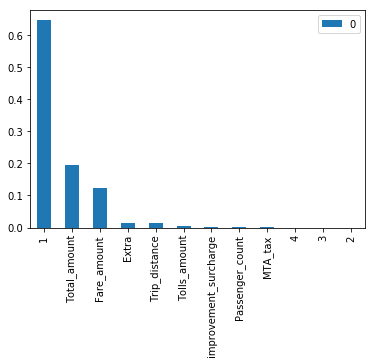

In [36]:
### Getting the feature importance for regression
rfr = RandomForestRegressor()
rfr.fit(X_train,y_train)
importance =  (sorted(zip(map(lambda x: round(x, 4), rfr.feature_importances_), X_train.columns), 
             reverse=True))
pd.DataFrame(importance, index=[x for (_,x) in importance]).plot(kind = 'bar')

For regression the important features are 1 (credit card payment type), Total_amount, Fare_amount

In [37]:
X_reg = df_sample[[1,'Total_amount','Fare_amount']]
X_train, X_test, y_train, y_test = train_test_split(X_reg,y_reg, test_size=0.3)

In [38]:
grid_rfr = { "n_estimators"      : range(120,180,10),
           "min_samples_split" : [2,4,8]  
           }

In [39]:
rfr = RandomForestRegressor()
random_search_rfr = GridSearchCV(rfr, grid_rfr, cv=10, n_jobs=-1)
random_search_rfr.fit(X_train, y_train)
best_random_rfr = random_search_rfr.best_estimator_
prediction_reg = best_random_rfr.predict(X_test)

In [40]:
print('Mean Squared Error is {}'.format(mean_squared_error(y_test,prediction_reg)))
print('R2 Score is {}'.format(r2_score(y_test,prediction_reg)))

Mean Squared Error is 3.8359012485347193
R2 Score is 0.9508722237982954


In [41]:
def predict_tip(dataframe):
    """
    This function predicts the percentage tip
    dataframe: Cleaned Dataframe
    """
    # Predictor variables based on importance checked by random forest classifier and regressor
    clas_predictors = [1,2,'Total_amount','Fare_amount','Trip_distance']
    reg_predictors = [1,'Total_amount','Fare_amount']
    
    # classify the trips which will give tips
    clas = best_random_rf.predict(dataframe[clas_predictors])
    
    # predict tips for those rows classified as 1
    return clas*best_random_rfr.predict(dataframe[reg_predictors])

In [42]:
ypred = predict_tip(df)
print ("Mean_squared_error:", mean_squared_error(ypred,df['Tip_percent']))
print ("R2_score:", r2_score(ypred,df['Tip_percent']))

Mean_squared_error: 4.80485382032
R2_score: 0.934925952101


Following steps were taken to finish part 4:

### Data Cleaning:
RateCodeID had values greater than 6 which is not possible according to the data dictionary, changed that to the most common value of the column.
Ehail_fee had mostly NaN's, dropped that column.
Fare_amount, Extra, MTA_tax, Tip_amount, Tolls_amount, improvement_surcharge and Total_amount had negative values. Converted them to the absolute values.
Trip_distance had a maximum value of over 600 miles. An interborugh travel of more than 100 miles was an outlier for our datset. Dropped values greater than 100 miles.
There were NaN values in Trip_type, changed those to the most common value of the column.

### Model building
Almost 60% of the trips didn't end up with a tip. A classifier was built first to predict which trips will end up in giving a tip. A regressor was built on top of that to find how much tip would be given. (Tip here meaning tip as a percentage of Total amount). Multiple classifiers were tried but random forest gave the best results and was chosen finally. Hyperparameter tuning for classifier was done using RandomSearchCV. Random forest was also chosen for regression and its hyperparameter was tuned using GridSearchCV. 

### Future Work
Feature Engineering was not tried, day of the week would have been a good indicator to see if people pay more on Weekdays or Weekends. It would have proved the hypothesis that people are less stressed on weekends and usually tip more.
Speed on the whole trip could have been looked as well. Hypothesis here being, if the speed is more, people might be scared and would tip less as compared to a trip where speed was maintained. Another idea could be that the person tipped more as the driver drove faster to make someone reach the destination in time. Would have been interesting to see that correlation. 





In [43]:
NYC = x_range, y_range = ((-74.05, -73.7), (40.6, 40.9))  ## selecting the range for the map around NYC

plot_width = int(750)
plot_height = int(plot_width//1.2)

def base_plot(tools='pan, wheel_zoom, reset', plot_width=plot_width, plot_height=plot_height, **plot_args):
    p = figure(tools=tools, plot_width=plot_width, plot_height=plot_height,
              x_range=x_range, y_range=y_range, outline_line_color=None,
              min_border=0, min_border_left=0, min_border_right=0,
              min_border_top=0, min_border_bottom=0, **plot_args)
    
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    return p

options = dict(line_color=None, fill_color='blue', size=5)

In [44]:
samples = df.sample(n=100000) ## Taking just 100000 samples for this visualization
j = base_plot()

j.circle(x=samples['Pickup_longitude'], y=samples['Pickup_latitude'], **options)
show(j)

In [45]:
samples = df.sample(n=100000)
j = base_plot()

j.circle(x=samples['Dropoff_longitude'], y=samples['Dropoff_latitude'], **options)
show(j)

#### The visualizations give a very clear understnading of where most of the pickup and dropoffs happen. The pickups happen mostly from Bronx, Brooklyn and Queens. Dropoffs look all over the place. The datashader gives a better perspective to the amount of dropoffs as well as pickups in and around the burroughs. Most of the dropoffs are very densely concentrated in Manhattan. Pickups are done from outside Manhattan and majorly from Brooklyn. Hypothesis is people working in Manhattan which is home to majority of tech and finance offices, like staying near their offices but Manhattan being such an expensive place isn't home to a large workforce but rather Brooklyn is.


#### The area in Northeast is Bronx, to Southeast is Brooklyn and to the right of Brooklyn is Queens. The area in the center is Manhattan

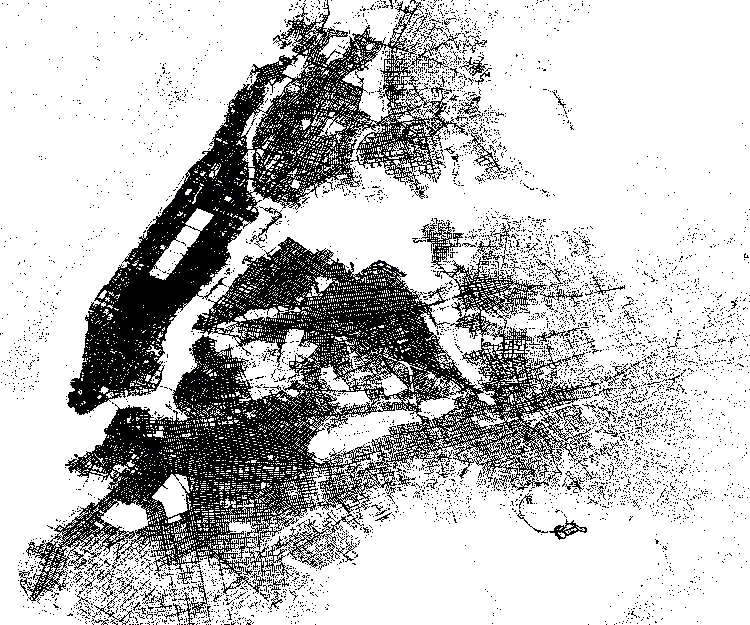

In [46]:
cvs = ds.Canvas(plot_width=plot_width, plot_height=plot_height, x_range=x_range, y_range=y_range)
agg = cvs.points(df, 'Dropoff_longitude', 'Dropoff_latitude', ds.count('Passenger_count')) ## aggregates the data using passenger count
img = tr_fns.shade(agg, cmap=["black", 'darkblue'], how='linear')
img

### Datashader visualization for dropoff

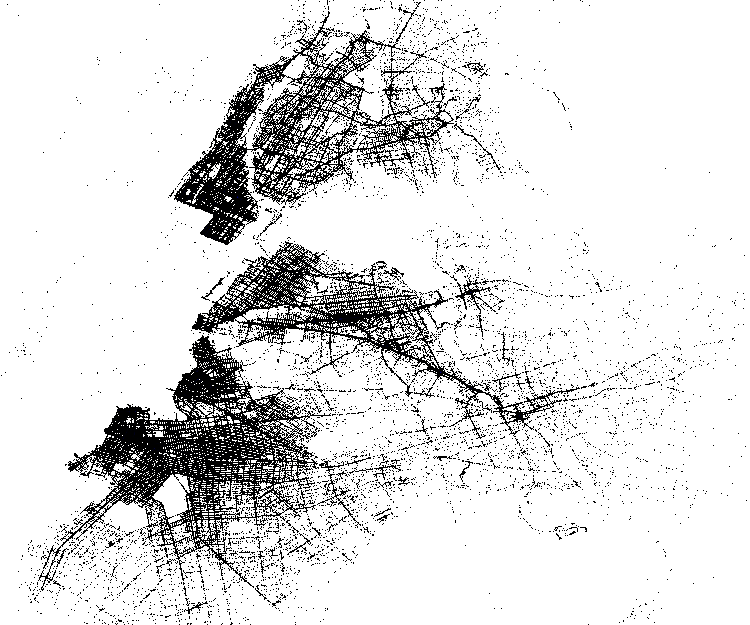

In [47]:
cvs = ds.Canvas(plot_width=plot_width, plot_height=plot_height, x_range=x_range, y_range=y_range)
agg = cvs.points(df, 'Pickup_longitude', 'Pickup_latitude', ds.count('Passenger_count'))
img = tr_fns.shade(agg, cmap=["black", 'darkblue'], how='linear')
img

### Datashader visualization for pickup